# 주제분석 2주차 패키지 과제 - 3팀 선형대수학팀 김지민

In [1]:
import pandas as pd
import numpy as np

## Chapter 1. 데이터 분할

### 1.1 데이터 불러오기

In [2]:
trainset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')

### 1.2 X와 Y 분리

In [3]:
trainset_x = trainset.drop('price', axis = 1)
trainset_y = trainset[['price']]

### 1.3 validation set 분할 - 첫번째

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
x_train, x_val, y_train, y_val = train_test_split(trainset_x, trainset_y, test_size=0.2)

### 1.4 질문

train_test_split을 통해 데이터를 나눌 경우 데이터셋이 어떠한 기준 없이 완전하게 랜덤한 방식으로 나뉜다. 따라서 현재 해당 아파트가 거래된 날짜에 대해 연도 변수와 월 / 일을 삼각변환 처리한 변수가 존재하는데, 이들이 마구잡이로 섞이게 되어 시간에 따른 추세의 변화를 분석에 사용하기에 적합하지 못하게 된다. 또한 서로 다른 train set과 validation set이 여러 개 만들어져 성능 추정에 반복적으로 활용되는 것이 아니라 각각 하나의 train set, validation set에 대해 한 번의 성능 추정만 이루어지기에 해당 문제를 해소할 수도 없다.

### 1.5 validation set 분할 - 두번째

In [6]:
train_x = trainset.loc[trainset['transaction_year'] != 4, trainset.columns != "price"]
train_y = trainset.loc[trainset['transaction_year'] != 4, trainset.columns == "price"]
validation_x = trainset.loc[trainset['transaction_year'] == 4, trainset.columns != "price"]
validation_y = trainset.loc[trainset['transaction_year'] == 4, trainset.columns == "price"]

### 1.5 캣부스트 인코딩 전에

In [7]:
# ! pip install category_encoders
from category_encoders.cat_boost import CatBoostEncoder

### 1.6 캣부스트 인코딩

In [8]:
cbe_encoder = CatBoostEncoder()
  
cbe_encoder.fit(train_x, train_y)
val_cbe = cbe_encoder.transform(validation_x)

In [9]:
val_cbe.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
2451,89176.597368,86280.203194,107.91,14,4,9,-1.000000e+00,-1.836970e-16
2452,89176.597368,86280.203194,151.81,10,4,9,-1.000000e+00,-1.836970e-16
2453,89176.597368,86280.203194,94.51,2,4,9,-2.449294e-16,1.000000e+00
2454,89176.597368,86280.203194,94.28,12,4,9,-2.449294e-16,1.000000e+00
2455,103789.156533,107170.755379,145.96,13,4,13,-1.000000e+00,-1.836970e-16


## Chapter 2. 릿지 회귀 (Ridge Regression)

### 2.1 상관계수 플랏

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [11]:
train_cbe = cbe_encoder.transform(train_x)

<AxesSubplot:>

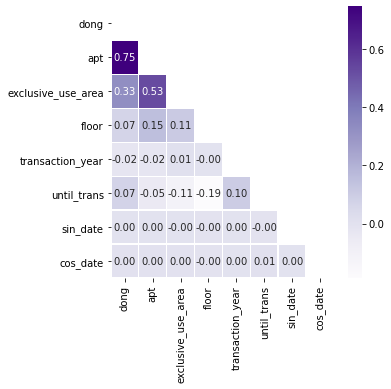

In [12]:
plt.figure(figsize=(5,5))

mask = np.zeros_like(train_cbe.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data = train_cbe.corr(), annot = True, fmt = '.2f', linewidths = .5, cmap = 'Purples', mask = mask)

상관계수 플랏을 그린 결과,  
'apt'와 'dong', 'apt'와 'exclusive_use_area'가 상당히 강한 양의 상관관계를, 'exclusive_use_area'와 'dong'이 양의 상관관계를, 'floor'가 'dong', 'apt', 'exclusive_use_area'와 매우 약한 양의 상관관계를, 'until_trans'는 'dong'과 'transaction_year'와는 매우 약한 양의 상관관계, 'apt', 'exclusive_use_area', 'floor'와는 매우 약한 음의 상관관계를 가지는 것으로 나타났다. 나머지 변수들은 변수들 간에 상관관계가 아예 없거나 없다고 보아도 무방할 정도의 약한 상관관계를 가지고 있었다. 릿지 회귀는 변수 간 상관관계가 높아도 좋은 성능을 보이기에 현 데이터셋에 대해 원활히 작동할 것으로 보인다.

### 2.2 해석과 무관하게 일단 릿지 튜닝

In [13]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt

In [14]:
alphas = np.array([0.00001, 0.0001, 0.001, 0.01, 0.1])

In [15]:
# 튜닝 결과 담을 데이터프레임
rdg_tuning = pd.DataFrame(index = range(0,5), columns = ['alpha', 'RMSE'])
rdg_tuning['alpha'] = alphas

In [16]:
for i in range(0,5):
    rdg = Ridge(alpha = alphas[i])
    rdg.fit(train_cbe, train_y)
    pred = rdg.predict(val_cbe)
    
    rdg_tuning.iloc[i,1] = sqrt(mean_squared_error(validation_y, pred))

In [17]:
pd.options.display.float_format = '{:.8f}'.format
rdg_tuning

,alpha,RMSE
0,0.00001000,15377.97765908
1,0.00010000,15377.97765926
2,0.00100000,15377.97766103
3,0.01000000,15377.97767870
4,0.10000000,15377.97785546


### 2.3 튜닝결과 시각화

<AxesSubplot:xlabel='alpha', ylabel='RMSE'>

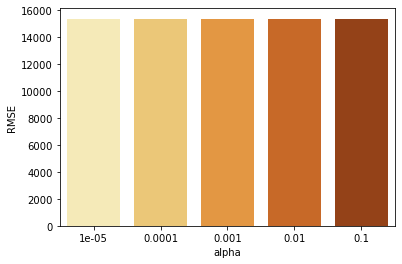

In [18]:
sns.barplot(data = rdg_tuning, x = "alpha", y = "RMSE", palette = "YlOrBr")

### 2.4 해석

릿지 튜닝 결과 현 상황에서의 릿지 회귀는 alpha의 값에 크게 상관 없이 비등비등한 성능을 가지는 것으로 나타났다. 그러나 그중에서는 가장 성능이 좋았던 것은 0.00001, 좋지 않았던 것은 0.1로 나타나 강한 페널티를 줄수록 성능이 약해진 것으로 보인다. 하지만 RMSE의 값이 모두 매우 크며 서로 유사하므로 튜닝이 잘 되지는 않았다고 할 수 있겠다. 애초에 변수들끼리 강한 상관관계를 가졌던 경우가 드물었는데, 릿지 회귀는 가중치를 아예 0으로 만드는 것이 아니라 그 절댓값이 0에 최대한 가까이 가게끔 할 뿐이기에 alpha값에 따른 결과에의 차이가 매우 작았던 것으로 생각된다.

### 2.5 그냥 선형 모형으로!

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
lr = LinearRegression()
lr.fit(train_cbe, train_y)
lr_pred = lr.predict(val_cbe)
sqrt(mean_squared_error(validation_y, lr_pred)) #RMSE

15377.977659062773

validation rmse의 측면에서 보았을 때 매우 근소한 차이로 linear regression이 더 좋은 성능을 보였으므로 선형 회귀 모형을 사용하는 쪽이 좋을 것으로 보인다.

## Chapter 3. LightGBM

In [21]:
#! pip install lightgbm

### 3.1 LightGBM 이해

LGBM은 2016년 Microsoft에 의해 개발된 GBM계열 알고리즘이다. 특징적인 것은 LGBM은 여타 모델과는 달리 분기가 수직적으로 이루어져 비대칭적 트리를 생성하기에 트리의 균형을 맞추기 위한 연산이 불필요하고, 히스토그램에 대한 관측 결과 계산된 근사치로 분할을 수행하기에 split point를 찾는 데에 쓰이는 연산도 불필요하다. 따라서 다른 모델들에 비해 속도도 빠르고 메모리도 적게 차지하며 그와 동시에 성능도 좋다는 여러 장점을 가지고 있다. 그러나 데이터셋의 크기가 작을 때엔 overfitting에 취약하다는 단점이 있다.

### 3.2 LGBM 튜닝

In [22]:
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor

In [23]:
learning_rates = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.99])

# 튜닝 결과 담을 데이터프레임
lgbm_tuning = pd.DataFrame(index = range(0,7), columns = ['learning rate', 'RMSE'])
lgbm_tuning['learning rate'] = learning_rates

In [24]:
for i in range(0,7):
    lgbm = LGBMRegressor(learning_rate = learning_rates[i])
    lgbm.fit(train_cbe, train_y)
    lgbm_pred = lgbm.predict(val_cbe)
    
    lgbm_tuning.iloc[i,1] = sqrt(mean_squared_error(validation_y, lgbm_pred))

In [25]:
lgbm_tuning

,learning rate,RMSE
0,0.01000000,20688.40132582
1,0.05000000,11209.65102700
2,0.10000000,10340.97469046
3,0.30000000,9725.42511357
4,0.50000000,9431.09437152
5,0.70000000,9726.41421830
6,0.99000000,10501.17737223


### 3.3 튜닝결과 시각화

<AxesSubplot:xlabel='learning rate', ylabel='RMSE'>

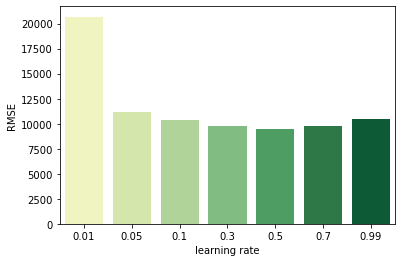

In [26]:
sns.barplot(data = lgbm_tuning, x = "learning rate", y = "RMSE", palette = "YlGn")

learning rate을 0.01에 이어 0.05로 두었을 때 급격히 RMSE가 감소했으며, 0.5로 학습되었을 때 LGBM의 성능이 가장 좋았다.

### 3.4 튜닝에 대하여 알아보자

#### 1. 그리드 서치(Grid Search)  
그리드 서치는 정하고자 하는 하이퍼 파라미터에 넣을 수 있는 값들을 전부 순차적으로 입력하여 가장 높은 성능을 보이는 하이퍼 파라미터를 찾는 탐색 방법이다. 고려하고자 하는 모든 경우의 수를 평가해볼 수 있다는 장점이 있지만, 그렇기에 굉장히 많은 시간이 소요되고 중요하지 않은 하이퍼 파라미터까지 전부 탐색해 비효율적이라는 단점이 있다.
  
#### 2. Random Search  
랜덤 서치는 이름처럼 하이퍼 파라미터 값을 '랜덤하게' 넣어 가장 우수한 성능을 보이는 하이퍼 파라미터를 선택해 모델을 짓는 방법이다. 정해진 범위 내에서 확률적으로 난수를 생성해 매개변수 조합을 선택하고 이를 모델의 하이퍼 파라미터로 넣기에 소요되는 시간도 적고, 그와 동시에 중요한 하이퍼 파라미터를 더 많이 탐색하여 성능도 그리드 서치에 비해 더 좋다. 하지만 다음 번에 넣어볼 하이퍼 파라미터 조합을 고를 때 이전 테스트 결과를 전혀 반영하지 않기 때문에 여전히 약간의 불필요한 탐색을 반복하는 경향이 있다.    
  
#### 3. Bayesian Optimization  
Bayesian Optimization은 앞서 알아본 두 방법과는 달리 미지의 목적 함수 f(x)를 지정하고 그 함숫값을 최대로 만드는 최적해를 찾는 것을 목적으로 한다. 즉 목적 함수 f와 하이퍼 파라미터 조합을 대상으로 대체 모델을 만들고, 평가를 거듭해 이를 업데이트해가며 최적의 하이퍼 파라미터 조합을 탐색하는 것이다. 이때 대체 모델이 f에 대해 확률적으로 추정한 결과를 바탕으로 다음 번에 탐색해볼 하이퍼 파라미터 조합을 추천해주는 함수인 acquisition function이 쓰인다. 이 방법은 이전의 테스트 결과를 반영하여 추출 범위를 좁히기 때문에 효율적 시행을 도모할 수 있어 시간 대비 성능이 훌륭하지만, 검색 공간의 차원을 높이려면 더 많은 샘플을 필요로 한다.

## Chapter 4. Test Set

### 4.1 test set 불러오기

In [27]:
testset_x = testset.drop('price', axis = 1)
testset_y = testset[['price']]

### 4.2 캣부스트 인코딩

In [28]:
cbe_encoder.fit(trainset_x, trainset_y)
trainset_cbe = cbe_encoder.transform(trainset_x)
testset_cbe = cbe_encoder.transform(testset_x)

### 4.3 최적의 파라미터 적합

In [29]:
# Linear Regression fit
lr = LinearRegression()
lr.fit(trainset_cbe, trainset_y)

LinearRegression()

In [30]:
# LGBM fit
lgbm = LGBMRegressor(learning_rate = 0.5)
lgbm.fit(trainset_cbe, trainset_y)

LGBMRegressor(learning_rate=0.5)

### 4.4 test set에 대해 평가

In [31]:
# Linear Regression evaluation
lr_pred = lr.predict(testset_cbe)
sqrt(mean_squared_error(testset_y, lr_pred))

17721.880605156573

In [32]:
# LGBM evaluation
lgbm_pred = lgbm.predict(testset_cbe)
sqrt(mean_squared_error(testset_y, lgbm_pred))

11909.118492076514

두 모델을 test set에 대해 평가한 결과, LGBM의 성능이 RMSE의 측면에서 훨씬 좋은 것으로 나타났다.